# Creating realistic aggregate consumption responses

From recent literature, we know that there are two important factors for HANK models:
1. Individual consumption responses depend on the liquid wealth distribution (how many assets you have depend on how large you respond due to precautionary and wealth effects)
2. While individual responses happen today, aggregate reponses are hump-shaped (Micro jumps and macro humps)

Therefore, to have realistic aggregate consumption reponses we need to match the liquid wealth distribution as well as incorporate (information) frictions.

## 1) Matching liquid wealth distribution 
["The Distribution of Wealth and the Marginal Propensity to Consume" (Carroll, Slacalek, Tokuoka, and White 2017; hereafter: "cstwMPC")](https://www.econ2.jhu.edu/people/ccarroll/papers/cstwMPC/)

https://github.com/econ-ark/DemARK/blob/master/notebooks/Micro-and-Macro-Implications-of-Very-Impatient-HHs.ipynb

There are many attempts in the literature to match the liquid wealth distribution in macro models and therefore, taking the microfoundations seriously! One attempt is by varying the patients factor of agents.


In [1]:
# This cell does some setup and imports generic tools used to produce the figures

from HARK.utilities import get_lorenz_shares, get_percentiles
from HARK.datasets import load_SCF_wealth_weights
from HARK.distribution import Uniform
# from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
from ConsIndShockModel_HANK import IndShockConsumerType
from copy import deepcopy
import warnings
from distutils.spawn import find_executable
import matplotlib.pyplot as plt
from IPython import get_ipython  # In case it was run from python instead of ipython
from tqdm import tqdm

import numpy as np

Generator = False  # Is this notebook the master or is it generated?
# Import related generic python packages

# Set how many digits past the decimal point should be printed?


def mystr(number):
    return "{:.4f}".format(number)


def decfmt4(number):
    return "{:.4f}".format(number)


def decfmt3(number):
    return "{:.3f}".format(number)


def decfmt2(number):
    return "{:.2f}".format(number)


def decfmt1(number):
    return "{:.1f}".format(number)


# This is a jupytext paired notebook that autogenerates BufferStockTheory.py
# which can be executed from a terminal command line via "ipython BufferStockTheory.py"
# But a terminal does not permit inline figures, so we need to test jupyter vs terminal
# Google "how can I check if code is executed in the ipython notebook"


def in_ipynb():
    try:
        if (
            str(type(get_ipython()))
            == "<class 'ipykernel.zmqshell.ZMQInteractiveShell'>"
        ):
            return True
        else:
            return False
    except NameError:
        return False


# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic("matplotlib", "inline")
else:
    get_ipython().run_line_magic("matplotlib", "auto")

# Import the plot-figure library matplotlib


# In order to use LaTeX to manage all text layout in our figures, we import rc settings from matplotlib.

plt.rc("font", family="serif")

# LaTeX is huge and takes forever to install on mybinder
# so if it is not installed then do not use it

iflatexExists = False
if find_executable("latex"):
    iflatexExists = True

plt.rc("text", usetex=iflatexExists)

# The warnings package allows us to ignore some harmless but alarming warning messages

warnings.filterwarnings("ignore")

In [2]:
# Import IndShockConsumerType
tau = 0
Y_ss = 1
T_ss = 0

# to add taxes, labor and wage
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

T = 300

In [3]:
# Define a dictionary with calibrated parameters
cstwMPC_calibrated_parameters = {
    "CRRA": 1.0,  # Coefficient of relative risk aversion
    "Rfree": 1.01 / (1.0 - 1.0 / 160.0),  # Survival probability,
    # Permanent income growth factor (no perm growth),
    "PermGroFac": [1.000**0.25],
    "PermGroFacAgg": 1.0,
    "BoroCnstArt": 0.0,
    "CubicBool": False,
    "vFuncBool": False,
    "PermShkStd": [
        (0.01 * 4 / 11) ** 0.5
    ],  # Standard deviation of permanent shocks to income
    "PermShkCount": 5,  # Number of points in permanent income shock grid
    "TranShkStd": [
        (0.01 * 4) ** 0.5
    ],  # Standard deviation of transitory shocks to income,
    "TranShkCount": 5,  # Number of points in transitory income shock grid
    "UnempPrb": 0.07,  # Probability of unemployment while working
    "IncUnemp": 0.15,  # Unemployment benefit replacement rate
    "UnempPrbRet": 0.07,
    "IncUnempRet": 0.15,
    "aXtraMin": 0.00001,  # Minimum end-of-period assets in grid
    # "aXtraMax": 40,  # Maximum end-of-period assets in grid
    # "aXtraCount": 32,  # Number of points in assets grid
    "aXtraExtra": [None],
    "aXtraNestFac": 3,  # Number of times to 'exponentially nest' when constructing assets grid
    "LivPrb": [1.0 - 1.0 / 160.0],  # Survival probability
    "DiscFac": 0.9855583,  # Default intertemporal discount factor; dummy value, will be overwritten
    "cycles": 0,
    "T_cycle": 1,
    "T_retire": 0,
    # Number of periods to simulate (idiosyncratic shocks model, perpetual youth)
    "T_sim": 1200,
    "T_age": 400,
    "IndL": 10.0 / 9.0,  # Labor supply per individual (constant),
    "aNrmInitMean": np.log(0.00001),
    "aNrmInitStd": 0.0,
    "pLvlInitMean": 0.0,
    "pLvlInitStd": 0.0,
    "AgentCount": 10000,

    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 20000000, #500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 400, #100,                     # Number of points in the base grid of "assets above minimum"

    # HANK params
    "taxrate" : [tau], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Y_ss - T_ss],
    "wage": [1.0],
    
    # Transition Matrix simulation parameters
    "mCount": 400,
    "mMax": 20000000,
    "mMin": 0.0001,
    "mFac": 3,
    
    ### HANK model params
    "labor":[1.0],
    "wage":[1.0],
    "tax_rate": [1.0],

    # Hank model bool
    "HANK":True,  
    "TranShkMean_Func": [function],
}


In [4]:
# This cell constructs the baseline consumer
BaselineType = IndShockConsumerType(**cstwMPC_calibrated_parameters)
BaselineType.solve()
BaselineType.initialize_sim()
BaselineType.simulate()


GPFRaw                 = 1.001674 
GPFNrm                 = 1.004946 
GPFAggLivPrb           = 0.995414 
Thorn = APF            = 1.001674 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.979399 
WRPF                   = 0.068558 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


{}

In [5]:
A_ss_BaselineType, C_ss_BaselineType = BaselineType.compute_steady_state()
CJACZ_BaselineType, AJACZ_BaselineType= BaselineType.calc_jacobian('labor',T)
CJACR_BaselineType, AJACR_BaselineType= BaselineType.calc_jacobian('Rfree',T)

GPFRaw                 = 1.001674 
GPFNrm                 = 1.004946 
GPFAggLivPrb           = 0.995414 
Thorn = APF            = 1.001674 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.979399 
WRPF                   = 0.068558 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


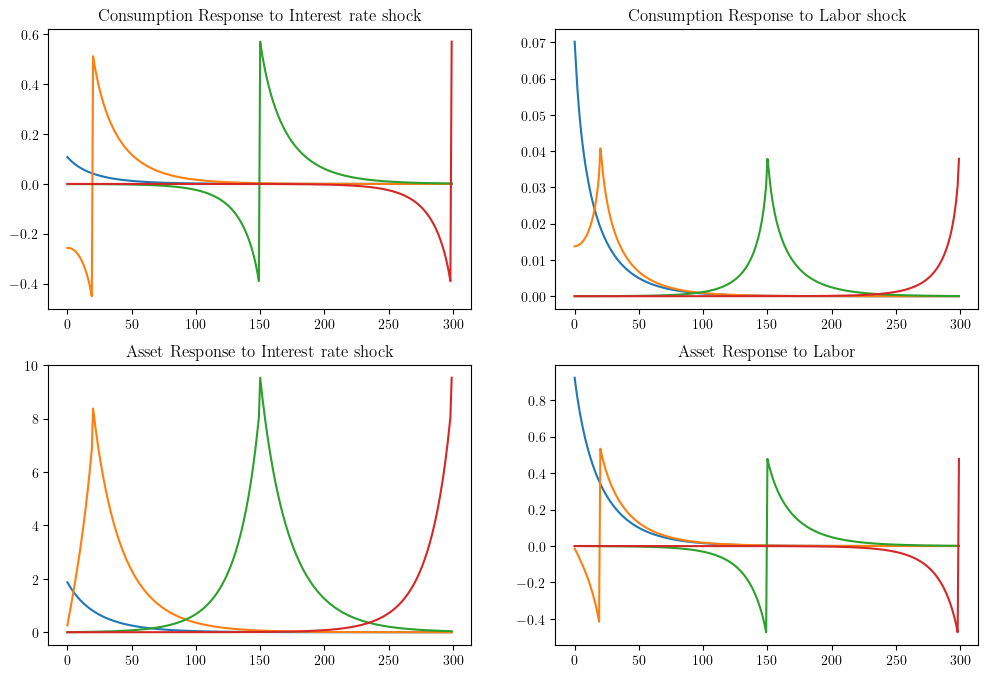

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Consumption Response to Interest rate shock
axs[0, 0].plot(CJACR_BaselineType.T[0])
axs[0, 0].plot(CJACR_BaselineType.T[20])
axs[0, 0].plot(CJACR_BaselineType.T[150])
axs[0, 0].plot(CJACR_BaselineType.T[-1])
axs[0, 0].set_title("Consumption Response to Interest rate shock")

# Consumption Response to Labor shock
axs[0, 1].plot(CJACZ_BaselineType.T[0])
axs[0, 1].plot(CJACZ_BaselineType.T[20])
axs[0, 1].plot(CJACZ_BaselineType.T[150])
axs[0, 1].plot(CJACZ_BaselineType.T[-1])
axs[0, 1].set_title("Consumption Response to Labor shock")

# Asset Response to Interest rate shock
axs[1, 0].plot(AJACR_BaselineType.T[0])
axs[1, 0].plot(AJACR_BaselineType.T[20])
axs[1, 0].plot(AJACR_BaselineType.T[150])
axs[1, 0].plot(AJACR_BaselineType.T[-1])
axs[1, 0].set_title("Asset Response to Interest rate shock")


# Asset Response to Labor
axs[1, 1].plot(AJACZ_BaselineType.T[0])
axs[1, 1].plot(AJACZ_BaselineType.T[20])
axs[1, 1].plot(AJACZ_BaselineType.T[150])
axs[1, 1].plot(AJACZ_BaselineType.T[-1])
axs[1, 1].set_title("Asset Response to Labor")

plt.show()

### Distribution of $\beta$

In [7]:
# Specify the distribution of the discount factor
num_types = 7  # number of types we want
DiscFac_mean = 0.9855583  # center of beta distribution
DiscFac_spread = 0.0085  # spread of beta distribution

# Here's how to use the tools to create time preference heterogeneity manually

DiscFac_dstn = (
    Uniform(DiscFac_mean - DiscFac_spread, DiscFac_mean + DiscFac_spread)
    .discretize(num_types)
    .atoms.flatten()
)



In [8]:
# Change the dictionary for each agent type
cstwMPC_calibrated_parameters_Dist = []
for i in range(num_types):
    temp_dict = deepcopy(cstwMPC_calibrated_parameters)
    temp_dict["DiscFac"] = DiscFac_dstn[i]
    cstwMPC_calibrated_parameters_Dist.append(temp_dict)

In [9]:
# Create 7 different types of agents
MyTypes = []  # initialize an empty list to hold our consumer types
for nn in range(num_types):
    # Now create the types, and append them to the list MyTypes
    NewType = IndShockConsumerType(**cstwMPC_calibrated_parameters_Dist[nn])
    NewType.update()
    # NewType.seed = nn  # give each consumer type a different RNG seed
    MyTypes.append(NewType)

In [10]:
# Progress bar keeps track interactively of how many have been made
CJACZ = []
AJACZ = []
CJACR = []
AJACR = []
A_ss = []
C_ss = []
for ThisType in tqdm(MyTypes):
    ThisType.solve()
    ThisType.initialize_sim()
    ThisType.simulate()
    A_ss_ThisType, C_ss_ThisType = ThisType.compute_steady_state()
    A_ss.append(A_ss_ThisType)
    C_ss.append(C_ss_ThisType)
    CJACZ_ThisType, AJACZ_ThisType= ThisType.calc_jacobian('labor',T)
    CJACR_ThisType, AJACR_ThisType= ThisType.calc_jacobian('Rfree',T)
    CJACZ.append(CJACZ_ThisType)
    AJACZ.append(AJACZ_ThisType)
    CJACR.append(CJACR_ThisType)
    AJACR.append(AJACR_ThisType)

  0%|          | 0/7 [00:00<?, ?it/s]GPFRaw                 = 0.994269 
GPFNrm                 = 0.997517 
GPFAggLivPrb           = 0.988055 
Thorn = APF            = 0.994269 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.972158 
WRPF                   = 0.068051 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.994269 
GPFNrm                 = 0.997517 
GPFAggLivPrb           = 0.988055 
Thorn = APF            = 0.994269 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.972158 
WRPF                   = 0.068051 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
 14%|█▍        | 1/7 [00:16<01:36, 16.07s/it]GPFRaw                 = 0.996738 
GPFNrm                 = 0.999994 
GPFAggLivPrb           = 0.990508 
Thorn = APF            = 0.996738 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF     

In [11]:
aLvl_all = np.concatenate([ThisType.state_now["aLvl"] for ThisType in MyTypes])
print(
    "The ratio of aggregate capital to permanent income is "
    + decfmt2(np.mean(aLvl_all))
)

The ratio of aggregate capital to permanent income is 10.56


In [12]:
# Compute Lorenz shares using the brute force approach

SCF_wealth, SCF_weights = load_SCF_wealth_weights()

pctiles = np.linspace(0.001, 0.999, 200)
sim_wealth_BetaDist = np.concatenate([ThisType.state_now["aLvl"] for ThisType in MyTypes])

# Compare it with the Lorenz curve from the SCF 
SCF_Lorenz_points = get_lorenz_shares(
    SCF_wealth, weights=SCF_weights, percentiles=pctiles
)
###
sim_Lorenz_points_BetaDist = get_lorenz_shares(sim_wealth_BetaDist, percentiles=pctiles)
sim_Lorenz_points_BetaPoint = get_lorenz_shares(BaselineType.state_now["aLvl"], percentiles=pctiles)

### Add limit point
pctiles = np.concatenate([[0.0], pctiles, [1.0]])
sim_Lorenz_points_BetaDist = np.concatenate([[0.0], sim_Lorenz_points_BetaDist, [1.0]])
sim_Lorenz_points_BetaPoint = np.concatenate([[0.0], sim_Lorenz_points_BetaPoint, [1.0]])
SCF_Lorenz_points = np.concatenate([[0.0], SCF_Lorenz_points, [1.0]])

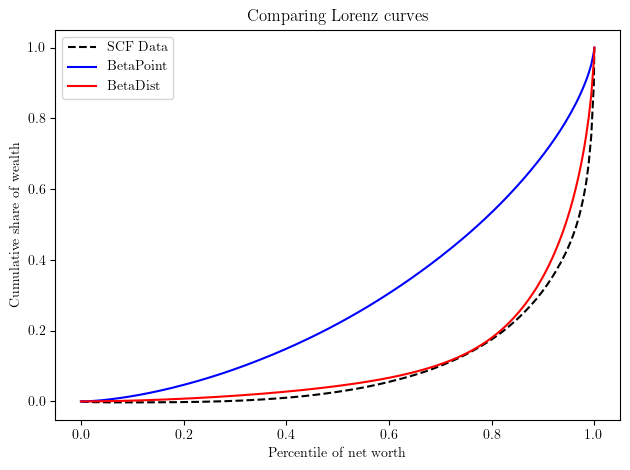

In [13]:
plt.plot(pctiles, SCF_Lorenz_points, "--k", label = "SCF Data")
plt.plot(pctiles, sim_Lorenz_points_BetaPoint, "-b", label = "BetaPoint")
plt.plot(pctiles, sim_Lorenz_points_BetaDist, "-r", label = "BetaDist")
plt.title("Comparing Lorenz curves")
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.legend()
plt.tight_layout()
plt.show(block=False)

### How do the iMPC look like? [WIP]

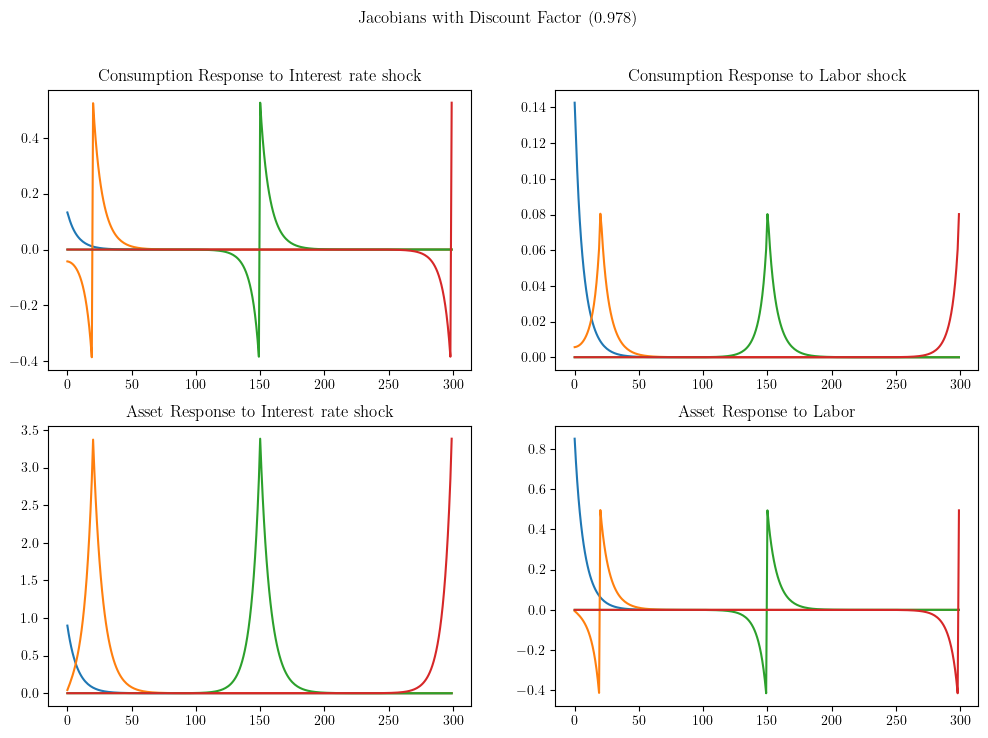

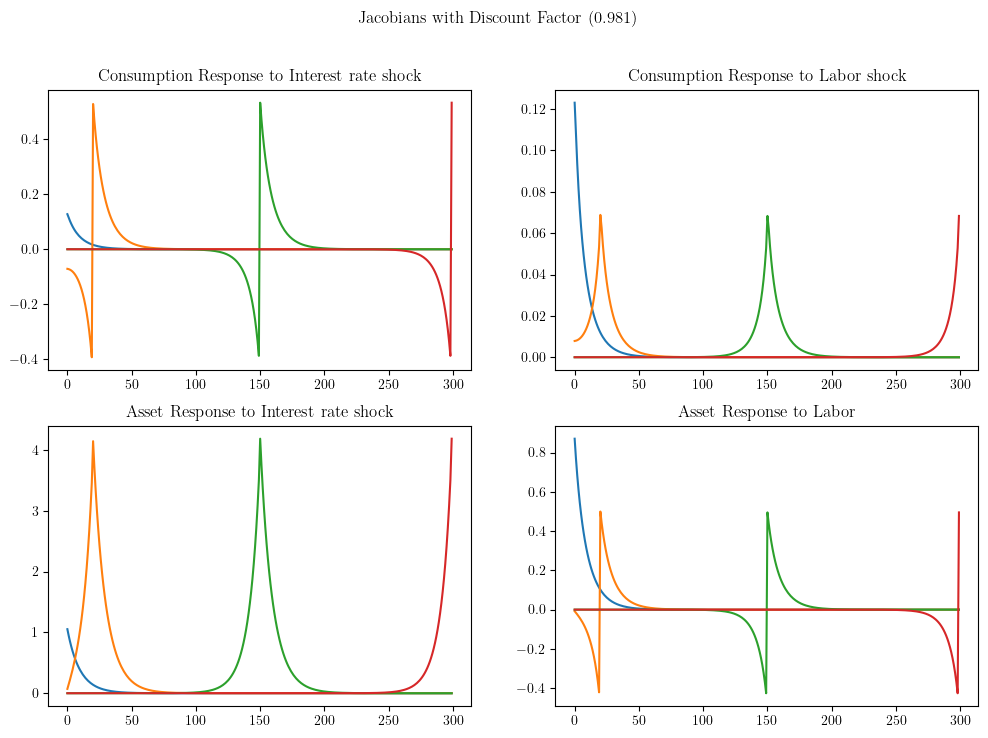

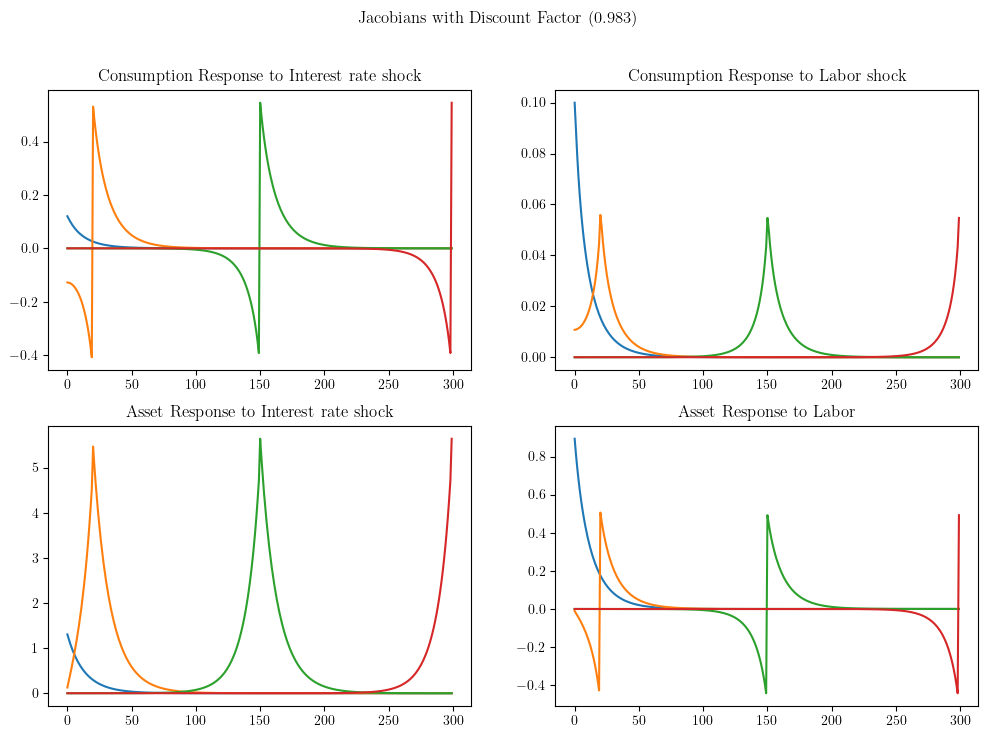

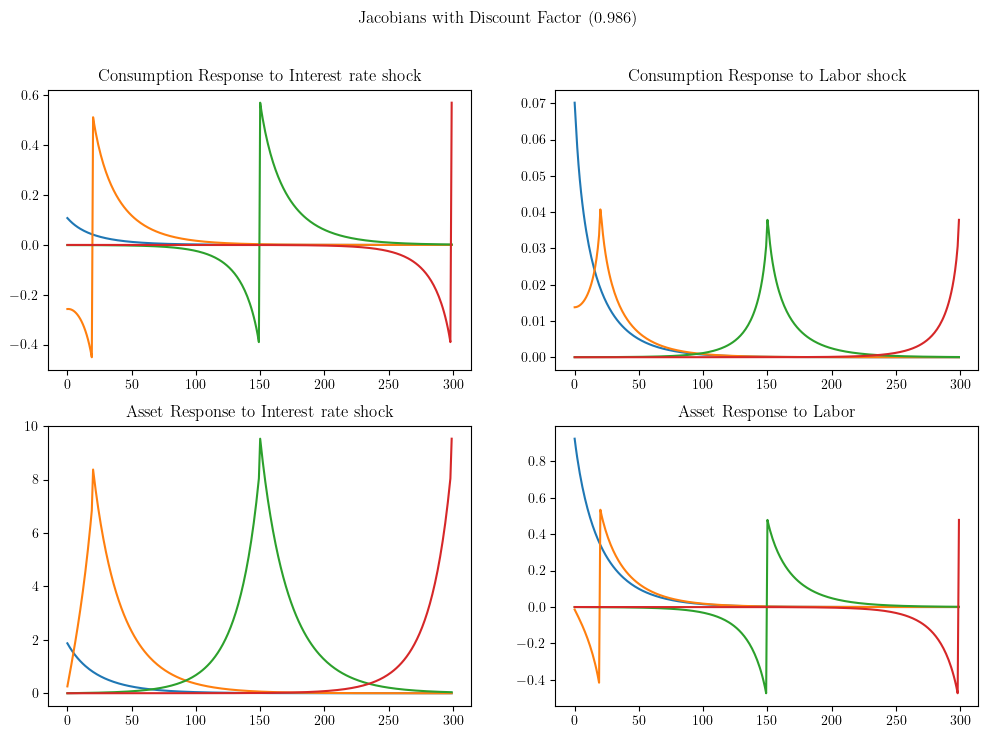

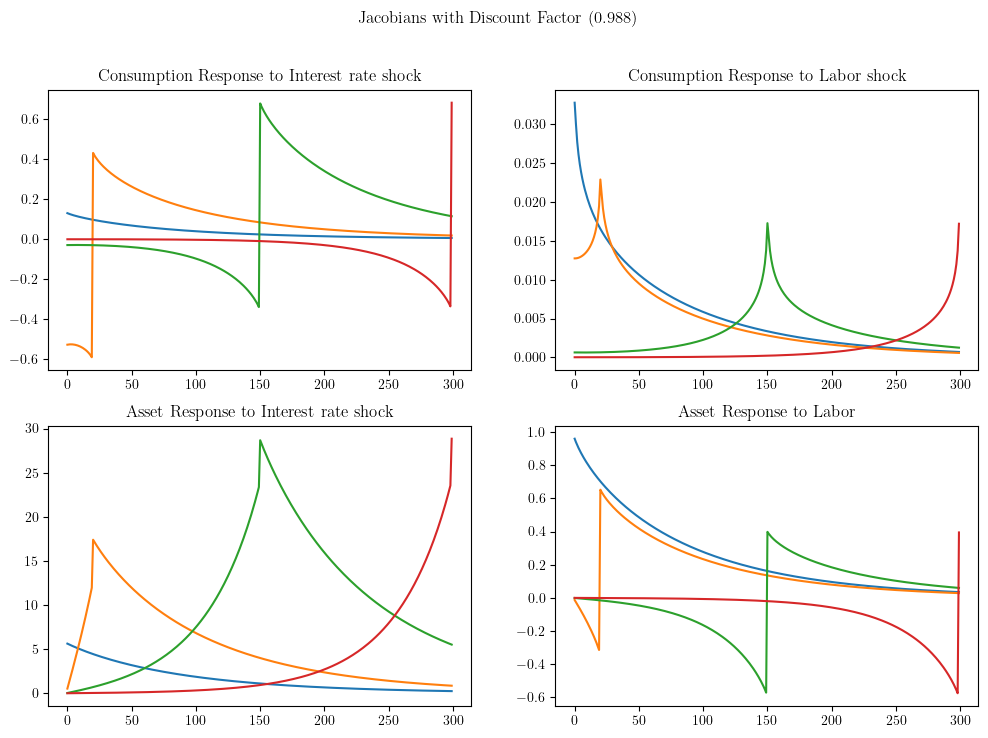

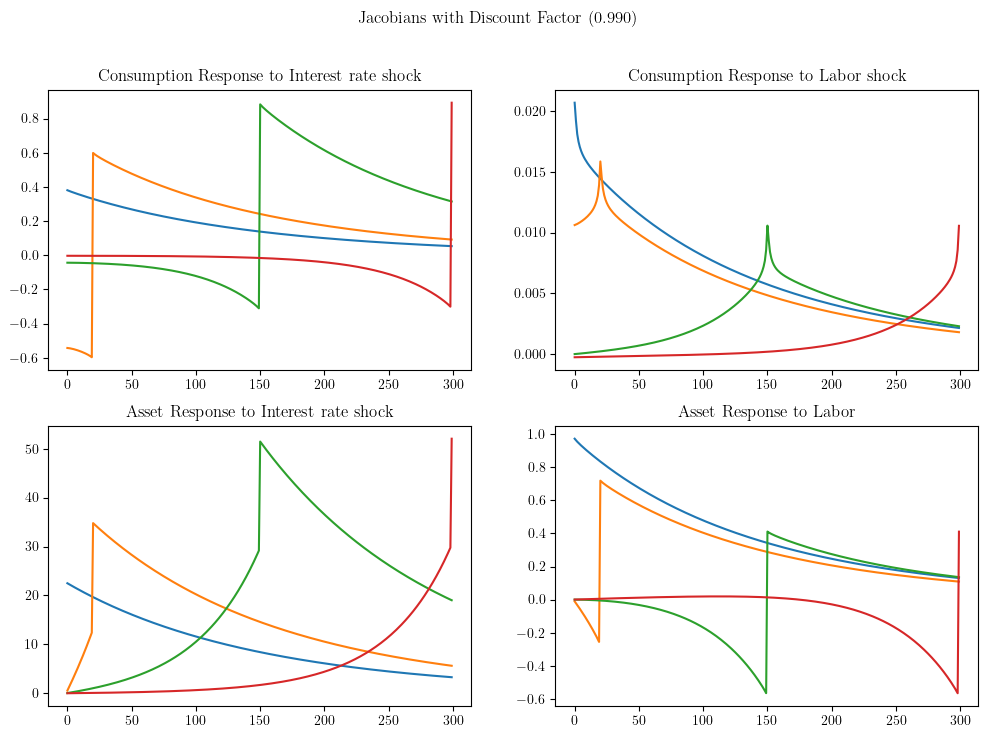

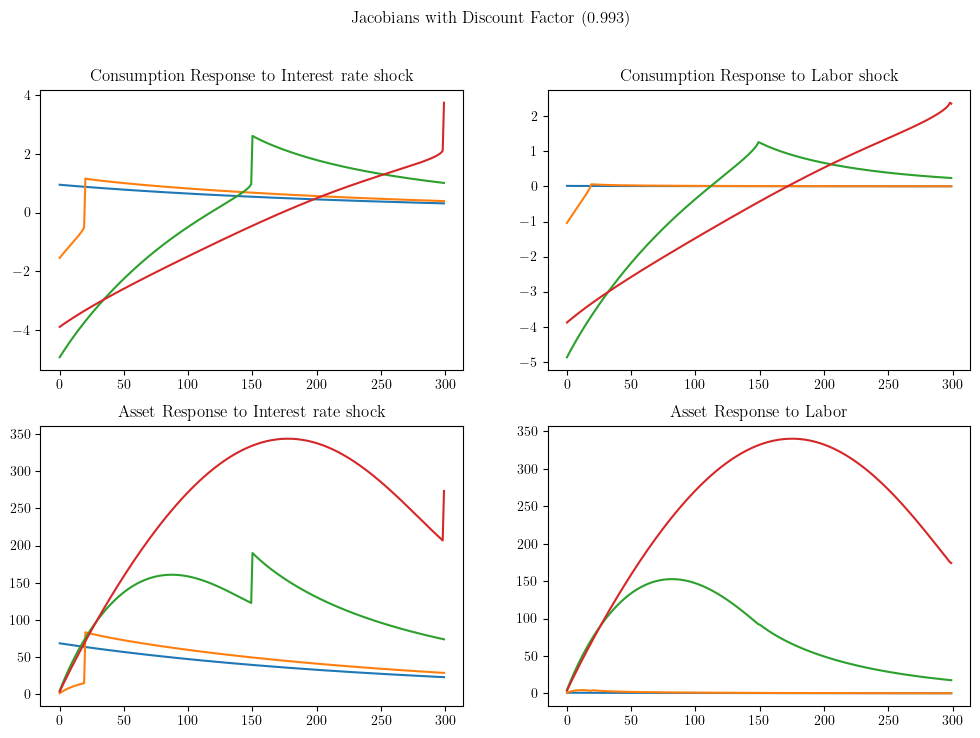

In [14]:
### Compare Jacobians for each type
for i in range(len(MyTypes)):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    # Consumption Response to Interest rate shock
    axs[0, 0].plot(CJACR[i].T[0])
    axs[0, 0].plot(CJACR[i].T[20])
    axs[0, 0].plot(CJACR[i].T[150])
    axs[0, 0].plot(CJACR[i].T[-1])
    axs[0, 0].set_title("Consumption Response to Interest rate shock")

    # Consumption Response to Labor shock
    axs[0, 1].plot(CJACZ[i].T[0])
    axs[0, 1].plot(CJACZ[i].T[20])
    axs[0, 1].plot(CJACZ[i].T[150])
    axs[0, 1].plot(CJACZ[i].T[-1])
    axs[0, 1].set_title("Consumption Response to Labor shock")

    # Asset Response to Interest rate shock
    axs[1, 0].plot(AJACR[i].T[0])
    axs[1, 0].plot(AJACR[i].T[20])
    axs[1, 0].plot(AJACR[i].T[150])
    axs[1, 0].plot(AJACR[i].T[-1])
    axs[1, 0].set_title("Asset Response to Interest rate shock")

    # Asset Response to Labor
    axs[1, 1].plot(AJACZ[i].T[0])
    axs[1, 1].plot(AJACZ[i].T[20])
    axs[1, 1].plot(AJACZ[i].T[150])
    axs[1, 1].plot(AJACZ[i].T[-1])
    axs[1, 1].set_title("Asset Response to Labor")

    fig.suptitle("Jacobians with Discount Factor ({:.3f})".format(DiscFac_dstn[i]))
    plt.show()


Wealthier agents adjust more strongly to interest rate shocks, but less to labor.

## 2) Micro jumps and macro humps
Looking at IRFs, we see a hump shaped aggregate response. But households should react instantaneously. How can we square these two facts? Many representative agent DSGE models use habit formations. That is, the current level of consumption creates a habit and changing this level up or down is costly. Therefore, reaction is sluggish.

This trick works in a model environment, but the micro foundations are not given. Another alternative is to use information frictions; eg sticky expectations a la [Carroll 2003](https://academic.oup.com/qje/article-abstract/118/1/269/1917034?login=false).
See [notebook](https://github.com/shade-econ/nber-workshop-2023/blob/main/Tutorials/Tutorial%205%20Information%20frictions.ipynb) and [paper](https://scholar.harvard.edu/straub/publications/jumps-humps)

The SSJ toolbox can incorporate information frictions very easily (assuming these frictions are homogeneous).

![Micro Jumps Macro Humps](../../figures/MicroJumpsMacroHumps.png)

The simple idea is to manipulate the Jacobian Matrix. Remember in column 10, we have the policy response given a shock happening in 10 periods. The first 9 entries in this column are the anticipation effect. Under FIRE (Full Information Rational Expectations) we assume every agent knows with certainty that the shock will occur in period 10.

With Sticky expectations, only a fraction of households adjusts their expectations and hence, not everyone knows/beliefs the shock is going to happen in period 10.

Let's see how that looks in code for the example from [02_HARK_meets_SSJ](02_HARK_meets_SSJ.ipynb):

In [15]:
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from sequence_jacobian.classes import JacobianDict, SteadyStateDict
from sequence_jacobian import het, simple, create_model              # functions
from scipy import optimize

In [16]:
# Defining steady state values of the economy
def fiscal_ss(B, r, G): 
    T = (1 + r) * B + G - B    
    return T

r_ss = 1.03 - 1
G_ss = .2
B_ss = 0.25 # this is lower than the tutorial by Straub et al. because need Higher MPC
Y_ss = 1.0
tau  = 0.0

T_ss = fiscal_ss(B_ss,r_ss,G_ss)
print('T_ss: ' +str(T_ss))

Z_ss = Y_ss - T_ss
C_ss = Y_ss - G_ss

print('Z_ss: ' +str(Z_ss))
print('C_ss: ' +str(Y_ss - G_ss))

T = 300 # Dimention of TxT Jacobian matrix

T_ss: 0.20750000000000002
Z_ss: 0.7925
C_ss: 0.8


In [17]:
HANK_Dict = {
    # Parameters shared with the perfect foresight model
    "Rfree": 1.0 + r_ss,                    # Interest factor on assets
    "LivPrb" : [.99375],                   # Survival probability

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.2],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,    
    
    # HANK params
    "taxrate" : [0.0], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Z_ss],
    "wage": [1.0],    
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.0,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
  
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    "BoroCnstArt": 0.0,
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
}

In [18]:
# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

HANK_Dict['TranShkMean_Func'] = [function]

In [19]:
### Target Steady State Asset
def ss_func(beta):
    HANK_Dict['DiscFac'] = beta
    Agent_func = IndShockConsumerType(**HANK_Dict, verbose = False)
    A_ss = Agent_func.compute_steady_state()[0]
    return A_ss
    

def ss_dif(beta):    
    return ss_func(beta) - Asset_target 

Asset_target = B_ss
DiscFac = optimize.brentq(ss_dif,.75,.99)

In [20]:
# Create a new agent
HANK_Dict['DiscFac'] = DiscFac
Agent_GE = IndShockConsumerType(**HANK_Dict, verbose = False)

In [21]:
A_ss, C_ss = Agent_GE.compute_steady_state()
MPC = Agent_GE.calc_jacobian('labor',T)[0][0][0]
print('Our general equilibrium agent has a discount rate of: ' + "%.2f" % Agent_GE.DiscFac +'. Where the steady state MPC is ' + "%.2f" % MPC + ' and Bond Holdings are ' + "%.2f" % A_ss)

Our general equilibrium agent has a discount rate of: 0.97. Where the steady state MPC is 0.26 and Bond Holdings are 0.25


In [22]:
CJACR, AJACR = Agent_GE.calc_jacobian('Rfree',T)
CJACZ, AJACZ = Agent_GE.calc_jacobian('labor', T)


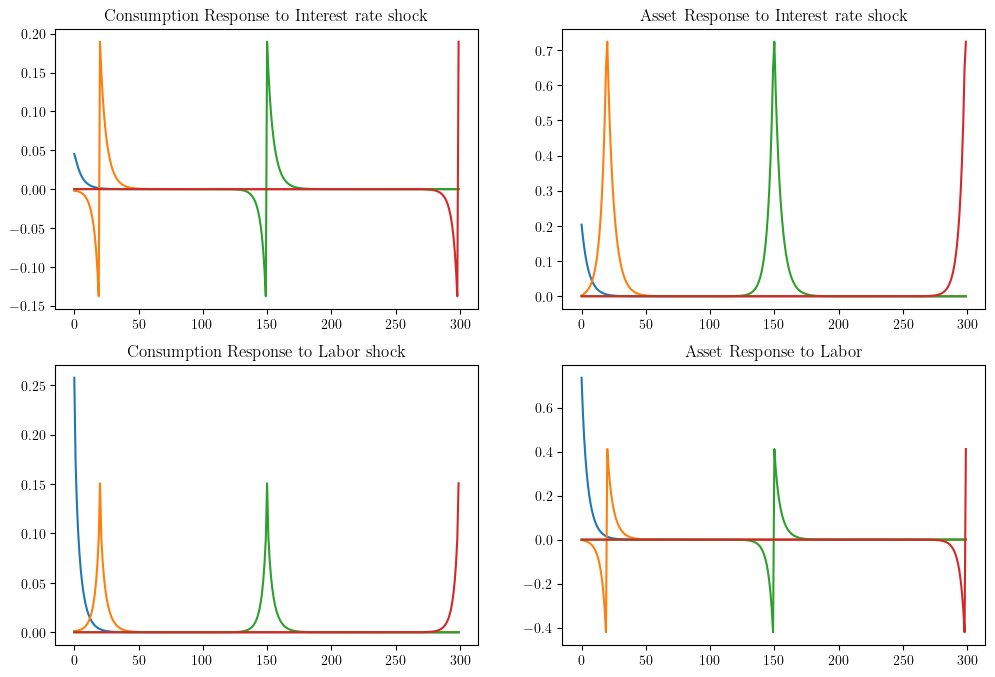

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Consumption Response to Interest rate shock
axs[0, 0].plot(CJACR.T[0])
axs[0, 0].plot(CJACR.T[20])
axs[0, 0].plot(CJACR.T[150])
axs[0, 0].plot(CJACR.T[-1])
axs[0, 0].set_title("Consumption Response to Interest rate shock")

# Asset Response to Interest rate shock
axs[0, 1].plot(AJACR.T[0])
axs[0, 1].plot(AJACR.T[20])
axs[0, 1].plot(AJACR.T[150])
axs[0, 1].plot(AJACR.T[-1])
axs[0, 1].set_title("Asset Response to Interest rate shock")

# Consumption Response to Labor shock
axs[1, 0].plot(CJACZ.T[0])
axs[1, 0].plot(CJACZ.T[20])
axs[1, 0].plot(CJACZ.T[150])
axs[1, 0].plot(CJACZ.T[-1])
axs[1, 0].set_title("Consumption Response to Labor shock")

# Asset Response to Labor
axs[1, 1].plot(AJACZ.T[0])
axs[1, 1].plot(AJACZ.T[20])
axs[1, 1].plot(AJACZ.T[150])
axs[1, 1].plot(AJACZ.T[-1])
axs[1, 1].set_title("Asset Response to Labor")

plt.show()

### Let's make them sticky

In [24]:
def makesticky(theta,x): # see appendix D3 of micro jumps macro humps paper

    xsticky=x*0

    xsticky[:,0]=x[:,0]    
    xsticky[0,1:x.shape[1]]=(1-theta)*x[0,1:x.shape[1]]    

    for t in range(1,x.shape[0]):
        for s in range(1,x.shape[1]):

            xsticky[t,s]=theta*xsticky[t-1,s-1]+(1-theta)*x[t,s]

    return xsticky 


def stick_jacob(J,theta):

    Jsticky=deepcopy(J)

    for i in J.outputs:

        for j in J.inputs:
            
            x=J[i][j]
            
            xsticky=makesticky(theta,x)
            Jsticky[i][j]=xsticky

    return Jsticky


In [25]:
# HARK_Jacobian_Dict = JacobianDict( { 'C' : {'Z' : CJACZ_BaselineType, 'r': CJACR_BaselineType} ,'A' : {'Z' : AJACZ_BaselineType, 'r': AJACR_BaselineType} } ) 
HARK_Jacobian_Dict = JacobianDict( { 'C' : {'Z' : CJACZ, 'r': CJACR} ,'A' : {'Z' : AJACZ, 'r': AJACR} } ) 

In [26]:
Jacobian_Sticky00 = stick_jacob(HARK_Jacobian_Dict, 0.0)
Jacobian_Sticky02 = stick_jacob(HARK_Jacobian_Dict, 0.2)
Jacobian_Sticky05 = stick_jacob(HARK_Jacobian_Dict, 0.5)
Jacobian_Sticky08 = stick_jacob(HARK_Jacobian_Dict, 0.8)
Jacobian_Sticky10 = stick_jacob(HARK_Jacobian_Dict, 1.0)

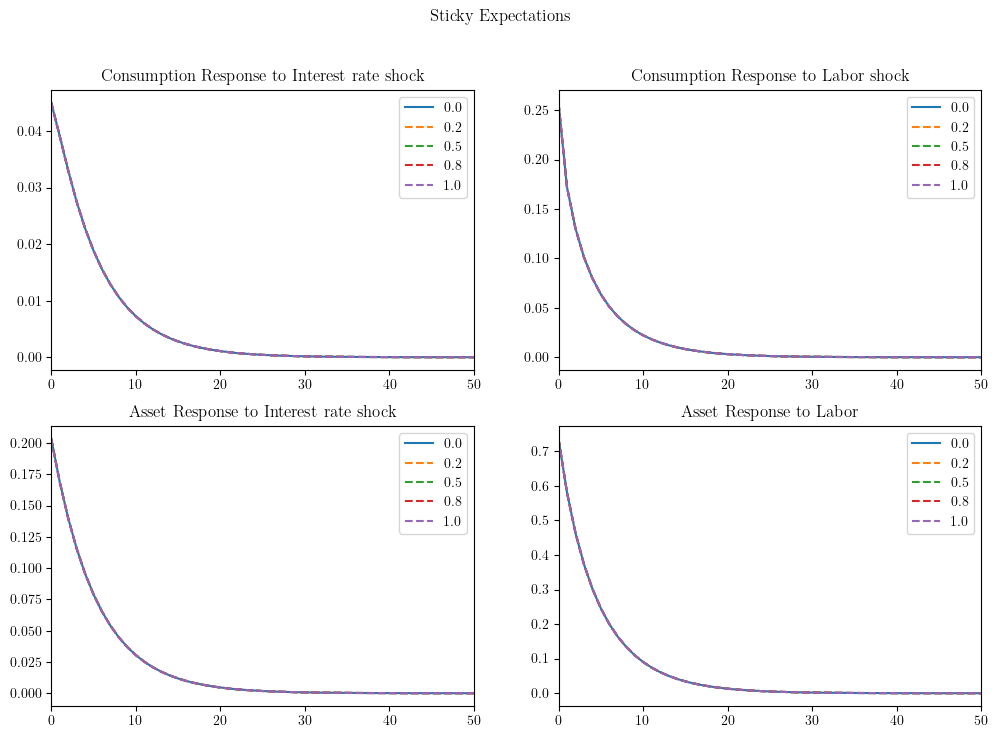

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Consumption Response to Interest rate shock
axs[0, 0].plot(Jacobian_Sticky00['C']['r'].T[0], label = '0.0')
axs[0, 0].plot(Jacobian_Sticky02['C']['r'].T[0], '--', label = '0.2')
axs[0, 0].plot(Jacobian_Sticky05['C']['r'].T[0], '--', label = '0.5')
axs[0, 0].plot(Jacobian_Sticky08['C']['r'].T[0], '--', label = '0.8')
axs[0, 0].plot(Jacobian_Sticky10['C']['r'].T[0], '--', label = '1.0')
axs[0, 0].set_title("Consumption Response to Interest rate shock")
axs[0, 0].legend()
axs[0, 0].set_xlim([0, 50])

# Consumption Response to Labor shock
axs[0, 1].plot(Jacobian_Sticky00['C']['Z'].T[0], label = '0.0')
axs[0, 1].plot(Jacobian_Sticky02['C']['Z'].T[0], '--', label = '0.2')
axs[0, 1].plot(Jacobian_Sticky05['C']['Z'].T[0], '--', label = '0.5')
axs[0, 1].plot(Jacobian_Sticky08['C']['Z'].T[0], '--', label = '0.8')
axs[0, 1].plot(Jacobian_Sticky10['C']['Z'].T[0], '--', label = '1.0')
axs[0, 1].set_title("Consumption Response to Labor shock")
axs[0, 1].legend()
axs[0, 1].set_xlim([0, 50])

# Asset Response to Interest rate shock
axs[1, 0].plot(Jacobian_Sticky00['A']['r'].T[0], label = '0.0')
axs[1, 0].plot(Jacobian_Sticky02['A']['r'].T[0], '--', label = '0.2')
axs[1, 0].plot(Jacobian_Sticky05['A']['r'].T[0], '--', label = '0.5')
axs[1, 0].plot(Jacobian_Sticky08['A']['r'].T[0], '--', label = '0.8')
axs[1, 0].plot(Jacobian_Sticky10['A']['r'].T[0], '--', label = '1.0')
axs[1, 0].set_title("Asset Response to Interest rate shock")
axs[1, 0].legend()
axs[1, 0].set_xlim([0, 50])

# Asset Response to Labor
axs[1, 1].plot(Jacobian_Sticky00['A']['Z'].T[0], label = '0.0')
axs[1, 1].plot(Jacobian_Sticky02['A']['Z'].T[0], '--', label = '0.2')
axs[1, 1].plot(Jacobian_Sticky05['A']['Z'].T[0], '--', label = '0.5')
axs[1, 1].plot(Jacobian_Sticky08['A']['Z'].T[0], '--', label = '0.8')
axs[1, 1].plot(Jacobian_Sticky10['A']['Z'].T[0], '--', label = '1.0')
axs[1, 1].set_title("Asset Response to Labor")
axs[1, 1].legend()
axs[1, 1].set_xlim([0, 50])

fig.suptitle("Sticky Expectations")
plt.show()

If a shock happens today, there is instant adjustment (Jump)

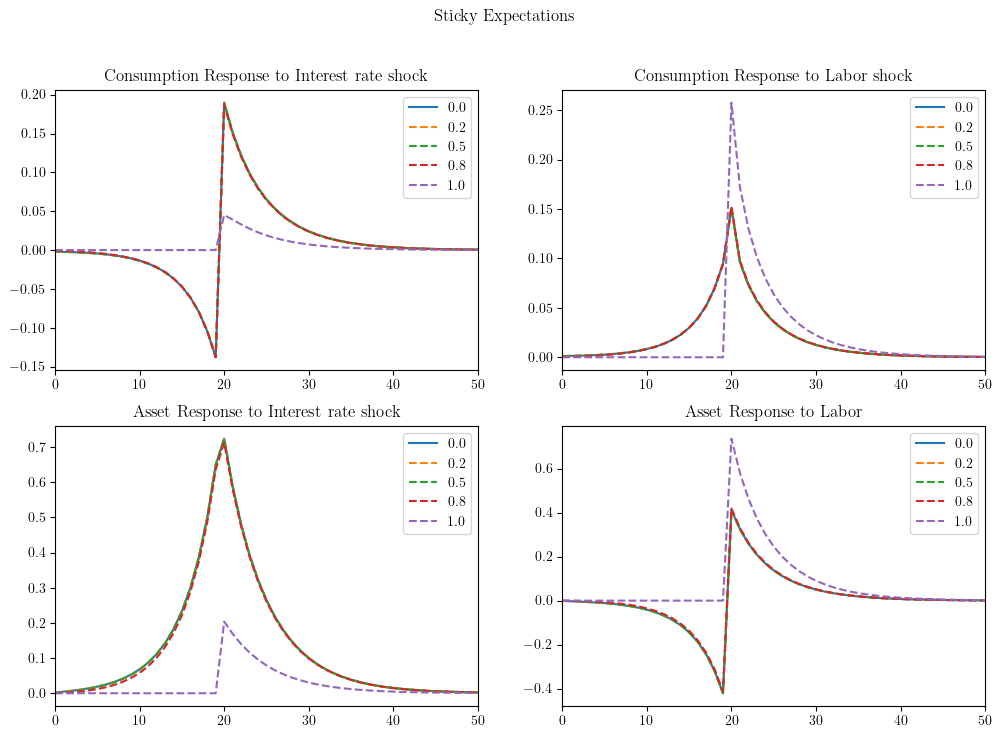

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Consumption Response to Interest rate shock
axs[0, 0].plot(Jacobian_Sticky00['C']['r'].T[20], label = '0.0')
axs[0, 0].plot(Jacobian_Sticky02['C']['r'].T[20], '--', label = '0.2')
axs[0, 0].plot(Jacobian_Sticky05['C']['r'].T[20], '--', label = '0.5')
axs[0, 0].plot(Jacobian_Sticky08['C']['r'].T[20], '--', label = '0.8')
axs[0, 0].plot(Jacobian_Sticky10['C']['r'].T[20], '--', label = '1.0')
axs[0, 0].set_title("Consumption Response to Interest rate shock")
axs[0, 0].legend()
axs[0, 0].set_xlim([0, 50])

# Consumption Response to Labor shock
axs[0, 1].plot(Jacobian_Sticky00['C']['Z'].T[20], label = '0.0')
axs[0, 1].plot(Jacobian_Sticky02['C']['Z'].T[20], '--', label = '0.2')
axs[0, 1].plot(Jacobian_Sticky05['C']['Z'].T[20], '--', label = '0.5')
axs[0, 1].plot(Jacobian_Sticky08['C']['Z'].T[20], '--', label = '0.8')
axs[0, 1].plot(Jacobian_Sticky10['C']['Z'].T[20], '--', label = '1.0')
axs[0, 1].set_title("Consumption Response to Labor shock")
axs[0, 1].legend()
axs[0, 1].set_xlim([0, 50])

# Asset Response to Interest rate shock
axs[1, 0].plot(Jacobian_Sticky00['A']['r'].T[20], label = '0.0')
axs[1, 0].plot(Jacobian_Sticky02['A']['r'].T[20], '--', label = '0.2')
axs[1, 0].plot(Jacobian_Sticky05['A']['r'].T[20], '--', label = '0.5')
axs[1, 0].plot(Jacobian_Sticky08['A']['r'].T[20], '--', label = '0.8')
axs[1, 0].plot(Jacobian_Sticky10['A']['r'].T[20], '--', label = '1.0')
axs[1, 0].set_title("Asset Response to Interest rate shock")
axs[1, 0].legend()
axs[1, 0].set_xlim([0, 50])

# Asset Response to Labor
axs[1, 1].plot(Jacobian_Sticky00['A']['Z'].T[20], label = '0.0')
axs[1, 1].plot(Jacobian_Sticky02['A']['Z'].T[20], '--', label = '0.2')
axs[1, 1].plot(Jacobian_Sticky05['A']['Z'].T[20], '--', label = '0.5')
axs[1, 1].plot(Jacobian_Sticky08['A']['Z'].T[20], '--', label = '0.8')
axs[1, 1].plot(Jacobian_Sticky10['A']['Z'].T[20], '--', label = '1.0')
axs[1, 1].set_title("Asset Response to Labor")
axs[1, 1].legend()
axs[1, 1].set_xlim([0, 50])

fig.suptitle("Sticky Expectations")
plt.show()

If there is a shock in the future, the anticipation and reaction is different

### GE IRfs (take an AR 1 shock)

In [29]:
HARK_SteadyState_Dict = SteadyStateDict({"C": C_ss, "r": r_ss, "Y": Y_ss, "B": B_ss, "G": G_ss, "A": A_ss})

In [30]:
@sj.simple
def fiscal(B, r, G, Y): 
    T = (1 + r) * B(-1) + G - B  # total tax burden
    Z = Y - T  # after tax income
    deficit = G - T
    
    return T, Z, deficit

@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = C + G - Y
    
    return asset_mkt, goods_mkt

In [31]:
# Create the model and specify attributes
HARK_HANK_Sticky00 = create_model([Jacobian_Sticky00, fiscal, mkt_clearing], name="Sticky 0.0")
HARK_HANK_Sticky02 = create_model([Jacobian_Sticky02, fiscal, mkt_clearing], name="Sticky 0.2")
HARK_HANK_Sticky05 = create_model([Jacobian_Sticky05, fiscal, mkt_clearing], name="Sticky 0.5")
HARK_HANK_Sticky08 = create_model([Jacobian_Sticky08, fiscal, mkt_clearing], name="Sticky 0.8")
HARK_HANK_Sticky10 = create_model([Jacobian_Sticky10, fiscal, mkt_clearing], name="Sticky 1.0")

dr = -0.01 * 0.7 ** np.arange(T) 
unknowns = ['Y']
targets = ['asset_mkt']
exogenous = ['r']
shocks_r = {'r': dr}

In [32]:
irfs_Sticky00 = HARK_HANK_Sticky00.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_r)
irfs_Sticky02 = HARK_HANK_Sticky02.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_r)
irfs_Sticky05 = HARK_HANK_Sticky05.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_r)
irfs_Sticky08 = HARK_HANK_Sticky08.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_r)
irfs_Sticky10 = HARK_HANK_Sticky10.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_r)

In [33]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(100 * irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

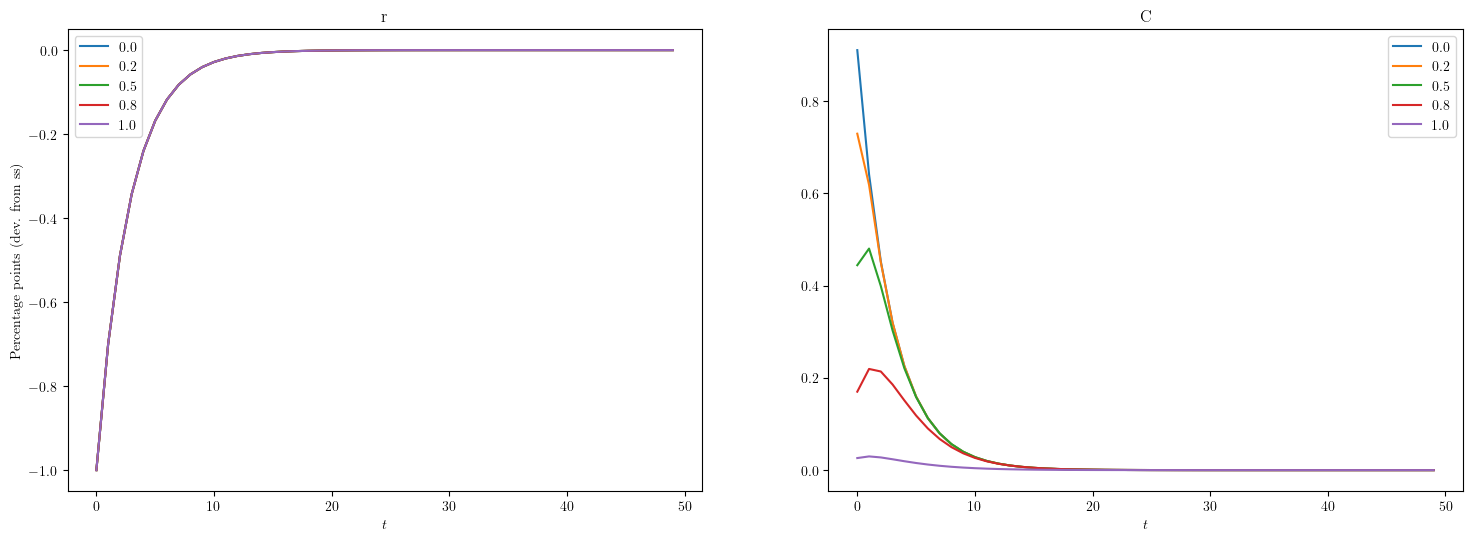

In [34]:
show_irfs([irfs_Sticky00, irfs_Sticky02, irfs_Sticky05, irfs_Sticky08, irfs_Sticky10], ['r', 'C'], labels=["0.0", "0.2", "0.5", "0.8", "1.0"])

When an interest rate cut hits, the IRF is hump-shaped!